In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
from functools import partial
import pickle as pkl
from fastai import *
from fastai.collab import *
from fastai.tabular import *

In [2]:
path=Path('~/.fastai/data/petfinder')

In [3]:
def uniquesInDf(df):
    uniqs = {}
    for col in df.columns:
        uniqs[col] = df[col].sort_values().unique().tolist()
    return uniqs

These are the variables in the csv file from kaggle

In [4]:
#Age probably needs some form of help because it clusters around certain numbers
NotVars=['Name','Description','AdoptionSpeed',]
catVars=['Type','Breed1','Breed2','Gender','Color1', 'Color2', 'Color3',
         'MaturitySize','FurLength','Vaccinated', 'Dewormed', 'Sterilized',
        'Health','State','RescuerID',]
contVars=['Age','Quantity','Fee','VideoAmt','PhotoAmt']
cols={'notVars':NotVars,'cat':catVars,'cont':contVars}

In [5]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


This is the metric used by kaggle

In [138]:
class QWK(Callback):
    def __init__(self, func):
        self.func, self.name = func, func.__name__

    def on_epoch_begin(self, **kwargs):
        self.outs=torch.FloatTensor().cpu()
        self.targs=torch.FloatTensor().cpu()

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        maxs=last_output.detach()
        self.outs=torch.cat((self.outs.cpu(),maxs.cpu()))
        self.targs=torch.cat((self.targs.cpu(),last_target.cpu()))

    def on_epoch_end(self, **kwargs):
        self.metric = self.func(torch.round(self.outs).long().numpy(),self.targs.long().numpy())

In [139]:
def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
        """
        Returns the confusion matrix between rater's ratings
        """
        assert(len(rater_a) == len(rater_b))
        if min_rating is None:
            min_rating = min(rater_a + rater_b)
        if max_rating is None:
            max_rating = max(rater_a + rater_b)
        num_ratings = int(max_rating - min_rating + 1)
        conf_mat = [[0 for i in range(num_ratings)]
                    for j in range(num_ratings)]
        for a, b in zip(rater_a, rater_b):
            conf_mat[a - min_rating][b - min_rating] += 1
        return conf_mat


    def histogram(ratings, min_rating=None, max_rating=None):
        """
        Returns the counts of each type of rating that a rater made
        """
        if min_rating is None:
            min_rating = min(ratings)
        if max_rating is None:
            max_rating = max(ratings)
        num_ratings = int(max_rating - min_rating + 1)
        hist_ratings = [0 for x in range(num_ratings)]
        for r in ratings:
            hist_ratings[r - min_rating] += 1
        return hist_ratings

    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

## Data Processing

In [ ]:
fullTrain=path/'train'/'train.csv'
fullTest=path/'test'/'test.csv'

In [ ]:
fullTrain=pd.read_csv(fullTrain)
fullTest=pd.read_csv(fullTest)

In [ ]:
types={
    'PhotoAmt':np.int64
}
fullTrain=fullTrain.astype(dtype=types)
fullTest=fullTest.astype(dtype=types)
print(fullTrain.dtypes)
print(fullTest.dtypes)
fullData=pd.concat([fullTrain,fullTest])

Standardizing the continuous variables, ie variables that vary over a range -inf->+inf

In [ ]:
for col in fullData[contVars]:
    fullTrain[col]=(fullTrain[col]-fullData[col].mean())/fullData[col].std()
    fullTest[col]=(fullTest[col]-fullData[col].mean())/fullData[col].std()
    fullData[col]=(fullData[col]-fullData[col].mean())/fullData[col].std()
fullData[contVars][0:5]

In [ ]:
fullTrain.to_csv(path/'train'/'normailizedTrain.csv',index=False)
fullTest.to_csv(path/'train'/'normailizedTest.csv',index=False)
fullData.to_csv(path/'train'/'normailizedData.csv',index=False)

Finding the unique values for each categorical variable. This is latter used for creating embeddings. 

In [ ]:
uniqCols = uniquesInDf(fullData)
print(uniqCols.keys())

In [ ]:
with open('unique_cols.json', 'w') as file:
     file.write(json.dumps(uniqCols))

In [ ]:
keysToIndex={}
for key in uniqCols.keys():
    keysToIndex[key]={}
    for i,uniq in enumerate(uniqCols[key]):
        keysToIndex[key][uniq]=i+1 #0 is not found
keysToIndex.keys()

In [ ]:
with open('keysToIndex.json', 'w') as file:
     file.write(json.dumps(keysToIndex))

In [ ]:
dataCats=fullData[cols['cat']].copy()
trainCats=fullTrain[cols['cat']].copy()
testCats=fullTest[cols['cat']].copy()
for column in cols['cat']:
    dataCats[column]=dataCats[column].map(keysToIndex[column])
    trainCats[column]=trainCats[column].map(keysToIndex[column])
    testCats[column]=testCats[column].map(keysToIndex[column])

In [ ]:
fullData[cols['cat']]=dataCats
fullTrain[cols['cat']]=trainCats
fullTest[cols['cat']]=testCats

In [ ]:
fullData.to_csv(path/'train'/'normCatData.csv',index=False)
fullTrain.to_csv(path/'train'/'normCatTrain.csv',index=False)
fullTest.to_csv(path/'train'/'normCatTest.csv',index=False)

## Test Data Exploration

In [ ]:
fullTrain=path/'train'/'train.csv'
fullTest=path/'test'/'test.csv'
fullTrain=pd.read_csv(fullTrain)
fullTest=pd.read_csv(fullTest)

In [ ]:
fullTest

In [ ]:
uniqTrain = uniquesInDf(fullTrain)
uniqTest = uniquesInDf(fullTest)

In [ ]:
uniqTrain['RescuerID']

In [ ]:
print(len(fullTest),len(fullTest.join(fullTrain,on='RescuerID',rsuffix='_rain',how='inner')))

Found here that RescuerId is different in train/test datasets. Must split this out as well when creating validation dataset

## Data Loading for Initial Embeddings

Trying to find an effective way to pretrain the embeddings for the categorical variables. 

In [ ]:
normalPath=path/'train'/'normCatData.csv'
fullData=pd.read_csv(normalPath)
valid=fullData.sample(frac=0.2, random_state=45321)
train=fullData.drop(valid.index)
[len(train),len(valid),len(valid)/len(train),len(fullData)]

In [ ]:
uniq_cols = uniquesInDf(fullData)
print(uniq_cols.keys())

In [ ]:
train.columns

In [ ]:
class PetDataset(Dataset):
    def __init__(self,cats,labels):
        self.cats=cats
        self.labels=labels
        if(len(self.cats)!=len(self.labels)):
            raise ValueError('Labels not same length as inputs!')
    def __len__(self):
        return len(self.cats)
    def __getitem__(self,idx):
        return torch.from_numpy(self.cats[idx]),torch.FloatTensor(self.labels[idx])

In [ ]:
embedCont=cols['cont'].copy()
embedCont

In [ ]:
trainDs=PetDataset(train[cols['cat']].values,train[embedCont].values)
validDs=PetDataset(valid[cols['cat']].values,valid[embedCont].values)
trainDs[0]

In [ ]:
trainDl=DataLoader(trainDs, batch_size=512,shuffle=True, num_workers=4)
validDl=DataLoader(validDs, batch_size=512,shuffle=False, num_workers=4)

## Pretraining Embeddings

In [ ]:
#Simple "deep" linear model for training embeddings
class SimpleLinearModel(nn.Module):
    def __init__(self,cols,uniq_cols):
        super(SimpleLinearModel, self).__init__()
        embeds=[]
        embed_sz=0
        for cat in cols['cat']:
            embed_sz+=max(min(len(uniq_cols[cat]),50),4)
            embeds.append(nn.Sequential(nn.Embedding(len(uniq_cols[cat])+1,max(min(len(uniq_cols[cat]),50),4)),nn.Dropout(0.2)))
        self.embeds=nn.ModuleList(embeds)
        self.bn1=nn.BatchNorm1d(embed_sz)
        self.l1=nn.Linear(embed_sz,100)#+len(cols['cont']
        self.relu1=nn.ReLU()
        self.bn2=nn.BatchNorm1d(self.l1.out_features)
        self.dp1=nn.Dropout(p=0.5)
        self.l2=nn.Linear(self.l1.out_features,5)
    def forward(self,cat):
        x=[e(cat[:,i]) for i,e in enumerate(self.embeds)]
        x=torch.cat(x,1)
        #x=torch.cat([x,cont],1)
        x=self.bn1(x)
        x=self.l1(x)
        x=self.relu1(x)
        x=self.bn2(x)
        x=self.dp1(x)
        return self.l2(x)

In [ ]:
embedCols=cols.copy()

In [ ]:
embedCols['cont']=embedCont

In [ ]:
model=SimpleLinearModel(embedCols,uniq_cols)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=0.01)

In [ ]:
criterion=nn.MSELoss()

In [ ]:
print(len(trainDl.dataset))
print(len(validDl.dataset))

In [ ]:
train[embedCont].min()
train[embedCont].std()

In [ ]:
db=DataBunch(trainDl,validDl)

In [ ]:
learn=Learner(data=db,model=model,loss_func=nn.MSELoss(),wd=0.01)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-1)

In [ ]:
learn.get_preds()

In [ ]:
for epoch in range(7):  # loop over the dataset multiple times
    print('epoch: '+str(epoch))
    running_loss = 0.0
    training_loss=0.0
    for i, data in enumerate(trainDl):
        # get the inputs
        cats, labels = data
        if(len(labels)<=1):
            break
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = model(cats)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 40))
            running_loss=0.0
    with torch.no_grad():
        outputs=torch.Tensor([])
        validLabels=torch.FloatTensor([])
        for i, data in enumerate(validDl):
            cats, labels = data
            outputs=torch.cat((outputs,model(cats).squeeze(dim=1)))
            validLabels=torch.cat((validLabels,labels.float()))
        loss = criterion(outputs, validLabels.float())#torch.unsqueeze(,1))
        validLoss = loss.item()
        avgDeviation=torch.sum(torch.abs(torch.sub(outputs,validLabels.float())))/len(trainDl.dataset)
        numBatches=len(trainDl.dataset)/trainDl.batch_size
        print('[%d] training loss: %.3f validation loss: %.3f avgDev: %.3f' %
                  (epoch + 1, training_loss/numBatches,validLoss,avgDeviation))
            

print('Finished Training')

In [ ]:
state=learn.model.state_dict()

In [ ]:
model.load_state_dict(state)

In [ ]:
with open('embeds.pkl', 'wb') as f:
    pkl.dump(learn.model.embeds.state_dict(),f, pkl.HIGHEST_PROTOCOL)

## Data Loading

The train and test sets do not overlap in rescuerIDs, so splitting based on this value

In [8]:
normalPath=path/'train'/'normCatTrain.csv'
fullTrain=pd.read_csv(normalPath)
fullData=pd.read_csv(path/'train'/'normCatData.csv')
validIndex=fullTrain.RescuerID.isin(pd.Series(fullTrain.RescuerID.unique()).sample(frac=0.1845, random_state=12345))
valid=fullTrain[validIndex]
train=fullTrain.drop(valid.index)
[len(train),len(valid),len(valid)/len(train),len(fullTrain)]

[12535, 2458, 0.19609094535301158, 14993]

In [9]:
uniq_cols = uniquesInDf(fullData)
print(uniq_cols.keys())

dict_keys(['AdoptionSpeed', 'Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Description', 'Dewormed', 'Fee', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Name', 'PetID', 'PhotoAmt', 'Quantity', 'RescuerID', 'State', 'Sterilized', 'Type', 'Vaccinated', 'VideoAmt'])


In [10]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [111]:
class PetDataset(Dataset):
    def __init__(self,conts,cats,labels):
        self.conts=conts
        self.cats=cats
        self.x=(conts,cats)
        self.labels=labels
        if(len(self.conts)!=len(self.cats)):
            raise ValueError('Catigorical and continuous variables should be same length')
        if(len(self.conts)!=len(self.labels)):
            raise ValueError('Labels not same length as inputs!')
    def __len__(self):
        return len(self.conts)
    def __getitem__(self,idx):
        return [torch.Tensor(self.conts[idx]),torch.from_numpy(self.cats[idx])],np.float32(self.labels[idx])

In [112]:
torch.Tensor(train['AdoptionSpeed'].values/4).dtype

torch.float32

In [113]:
trainDs=PetDataset(train[cols['cont']].values,train[cols['cat']].values,train['AdoptionSpeed'].values)
validDs=PetDataset(valid[cols['cont']].values,valid[cols['cat']].values,valid['AdoptionSpeed'].values)
trainDs[0]

([tensor([-0.4211, -0.3905,  0.9607, -0.1630, -0.8167]),
  tensor([   2,  181,    1,    1,    1,    7,    1,    1,    1,    2,    2,    2,
             1,    3, 3735])],
 2.0)

In [114]:
trainDl=DataLoader(trainDs, batch_size=12535,shuffle=True, num_workers=4)
validDl=DataLoader(validDs, batch_size=128,shuffle=False, num_workers=4)

In [115]:
db=DataBunch(trainDl,validDl)

In [116]:
trainDs[3]

([tensor([-0.3663, -0.3905,  1.5808, -0.1630,  1.1734]),
  tensor([   1,  189,    1,    2,    1,    2,    1,    2,    1,    1,    1,    2,
             1,   13, 4108])],
 2.0)

## Simple Model

In [117]:
uniq_cols.keys()

dict_keys(['AdoptionSpeed', 'Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Description', 'Dewormed', 'Fee', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'Name', 'PetID', 'PhotoAmt', 'Quantity', 'RescuerID', 'State', 'Sterilized', 'Type', 'Vaccinated', 'VideoAmt'])

In [259]:
class SimpleLinearModel(nn.Module):
    def __init__(self,cols,uniq_cols):
        super(SimpleLinearModel, self).__init__()
        embeds=[]
        embed_sz=0
        for cat in cols['cat']:
            embed_sz+=max(min(len(uniq_cols[cat]),50),4)
            embeds.append(nn.Sequential(nn.Embedding(len(uniq_cols[cat])+1,max(min(len(uniq_cols[cat]),50),4)),
                          nn.Dropout(p=0.1)))
        self.embeds=nn.ModuleList(embeds)
        self.bn1=nn.BatchNorm1d(embed_sz+len(cols['cont']))
        self.dp1=nn.Dropout(p=0.2)
        self.layers=nn.ModuleList([
            nn.Linear(embed_sz+len(cols['cont']),100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.5),
            nn.Linear(embed_sz+len(cols['cont'])+100,50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Dropout(p=0.5),
            nn.Linear(embed_sz+len(cols['cont'])+100+50,1)
        ])
    def forward(self,cont,cat):
        #cont=x[0]
        #cat=x[1]
        x=[e(cat[:,i]) for i,e in enumerate(self.embeds)]
        x=torch.cat(x,1)
        x=torch.cat([x,cont],1)
        x=self.bn1(x)
        x=self.dp1(x)
        lin_in=torch.FloatTensor().cuda()#x.clone()
        #first_lin=True
        for l in self.layers:
            if(isinstance(l,nn.Linear)):
                lin_in=torch.cat((lin_in,x),1)
                x=l(lin_in)
                #lin_cat=range(0,len(lin_out[0])-len(x[0]))
                #x=l(x) if(first_lin) else l(torch.cat([x,lin_out[:,lin_cat]],1))
                #x=l(x) if(first_lin) else l(torch.cat([x,lin_out],1))
                #lin_out=torch.cat([x,lin_out],1)
                #first_lin=False
            else:
                x=l(x)
        return torch.squeeze(torch.sigmoid(x.mul(2)).mul(5),1)

dmesg for cuda errors

In [260]:
!dmesg | tail -n 5

[2236835.847975] usb 5-1: New USB device strings: Mfr=3, Product=1, SerialNumber=2
[2236835.847978] usb 5-1: Product: Back-UPS ES 600G FW:905.W1 .D USB FW:W1 
[2236835.847981] usb 5-1: Manufacturer: APC
[2236835.847984] usb 5-1: SerialNumber: 4B1528P23736  
[2236835.968953] hid-generic 0003:051D:0002.000C: hiddev0,hidraw0: USB HID v1.10 Device [APC Back-UPS ES 600G FW:905.W1 .D USB FW:W1 ] on usb-0000:07:00.0-1/input0


In [261]:
model=SimpleLinearModel(cols,uniq_cols).cuda()

In [262]:
embeds=pkl.load(open('embeds.pkl',mode='rb'))

In [263]:
model.embeds.load_state_dict(embeds)

In [264]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=0.1, betas=(0.9,0.99))

In [265]:
criterion=nn.MSELoss()#partial(quadratic_weighted_kappa, min_rating=None, max_rating=None)

In [266]:
learn=Learner(data=db,model=model,loss_func=nn.MSELoss(),metrics=QWK(quadratic_weighted_kappa),wd=0.01)

In [267]:
learn.layer_groups

[Sequential(
   (0): Embedding(3, 4)
   (1): Dropout(p=0.1)
   (2): Embedding(190, 50)
   (3): Dropout(p=0.1)
   (4): Embedding(149, 50)
   (5): Dropout(p=0.1)
   (6): Embedding(4, 4)
   (7): Dropout(p=0.1)
   (8): Embedding(8, 7)
   (9): Dropout(p=0.1)
   (10): Embedding(8, 7)
   (11): Dropout(p=0.1)
   (12): Embedding(7, 6)
   (13): Dropout(p=0.1)
   (14): Embedding(5, 4)
   (15): Dropout(p=0.1)
   (16): Embedding(4, 4)
   (17): Dropout(p=0.1)
   (18): Embedding(4, 4)
   (19): Dropout(p=0.1)
   (20): Embedding(4, 4)
   (21): Dropout(p=0.1)
   (22): Embedding(4, 4)
   (23): Dropout(p=0.1)
   (24): Embedding(4, 4)
   (25): Dropout(p=0.1)
   (26): Embedding(15, 14)
   (27): Dropout(p=0.1)
   (28): Embedding(7114, 50)
   (29): Dropout(p=0.1)
   (30): BatchNorm1d(221, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (31): Dropout(p=0.2)
   (32): Linear(in_features=221, out_features=100, bias=True)
   (33): ReLU()
   (34): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=

In [268]:
layer_groups = [model.embeds,
    nn.ModuleList([model.bn1,model.dp1,model.layers])]
learn.layer_groups=layer_groups

In [269]:
learn.layer_groups

[ModuleList(
   (0): Sequential(
     (0): Embedding(3, 4)
     (1): Dropout(p=0.1)
   )
   (1): Sequential(
     (0): Embedding(190, 50)
     (1): Dropout(p=0.1)
   )
   (2): Sequential(
     (0): Embedding(149, 50)
     (1): Dropout(p=0.1)
   )
   (3): Sequential(
     (0): Embedding(4, 4)
     (1): Dropout(p=0.1)
   )
   (4): Sequential(
     (0): Embedding(8, 7)
     (1): Dropout(p=0.1)
   )
   (5): Sequential(
     (0): Embedding(8, 7)
     (1): Dropout(p=0.1)
   )
   (6): Sequential(
     (0): Embedding(7, 6)
     (1): Dropout(p=0.1)
   )
   (7): Sequential(
     (0): Embedding(5, 4)
     (1): Dropout(p=0.1)
   )
   (8): Sequential(
     (0): Embedding(4, 4)
     (1): Dropout(p=0.1)
   )
   (9): Sequential(
     (0): Embedding(4, 4)
     (1): Dropout(p=0.1)
   )
   (10): Sequential(
     (0): Embedding(4, 4)
     (1): Dropout(p=0.1)
   )
   (11): Sequential(
     (0): Embedding(4, 4)
     (1): Dropout(p=0.1)
   )
   (12): Sequential(
     (0): Embedding(4, 4)
     (1): Dropout(p=

In [270]:
learn.freeze()

In [271]:
trainDs[0]

([tensor([-0.4211, -0.3905,  0.9607, -0.1630, -0.8167]),
  tensor([   2,  181,    1,    1,    1,    7,    1,    1,    1,    2,    2,    2,
             1,    3, 3735])],
 2.0)

In [272]:
labels=[]
for input,label in trainDs:
    labels.append(label)

Counts of the label possibilities

In [273]:
counts={}
for i in range(0,7):
    counts[i]=labels.count(torch.Tensor([i]))

In [274]:
counts

{0: 345, 1: 2567, 2: 3421, 3: 2760, 4: 3442, 5: 0, 6: 0}

In [275]:
torch.max(learn.get_preds(learn.data.train_ds)[0])

tensor(4.2068)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


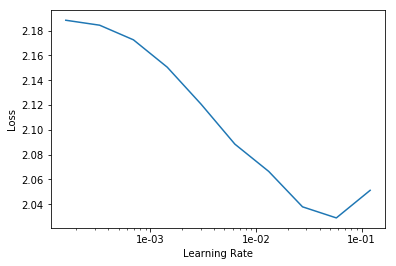

In [276]:
learn.lr_find(num_it=25)
learn.recorder.plot()

In [277]:
next(iter(learn.data.train_dl))

[[tensor([[-0.5307, -0.3905, -0.2794, -0.1630,  0.3205],
          [-0.4211,  0.9409, -0.2794, -0.1630,  0.3205],
          [ 0.7297, -0.3905, -0.2794, -0.1630, -0.5324],
          ...,
          [-0.5307,  0.9409, -0.2794, -0.1630, -0.2481],
          [ 2.7026, -0.3905, -0.2794, -0.1630, -0.8167],
          [-0.3115, -0.3905, -0.2794, -0.1630, -0.8167]], device='cuda:0'),
  tensor([[   1,  189,    1,  ...,    1,    6, 1280],
          [   2,  181,    1,  ...,    1,    3, 5536],
          [   1,  189,    1,  ...,    1,   13, 1162],
          ...,
          [   2,  150,    1,  ...,    1,    3, 6283],
          [   1,  189,    1,  ...,    1,    1, 5617],
          [   2,  150,    1,  ...,    1,    3, 3812]], device='cuda:0')],
 tensor([2., 1., 2.,  ..., 1., 4., 1.], device='cuda:0')]

In [278]:
learn.fit_one_cycle(4,5e-2)

epoch,train_loss,valid_loss,quadratic_weighted_kappa
1,2.191264,1.771946,0.040693
2,1.995786,1.819909,0.170897
3,2.154392,3.508936,0.108046
4,2.501998,2.580083,0.165572


In [279]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


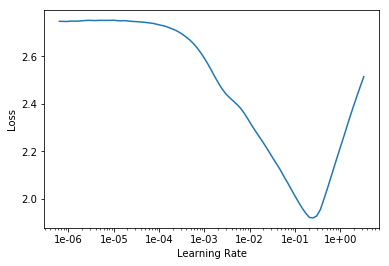

In [280]:
learn.lr_find()
learn.recorder.plot()

In [258]:
learn.fit_one_cycle(8,slice(1e-1/1000.0,1e-1))

epoch,train_loss,valid_loss,quadratic_weighted_kappa
1,2.920192,1.810673,0.258474
2,2.484273,5.859037,-0.032933
3,3.620413,4.248208,0.113789
4,3.780851,6.847684,0.018113
5,4.244784,5.559865,0.107628
6,4.468586,5.477168,0.153050
7,4.530522,5.577027,0.147694
8,4.526551,5.447836,0.157026


In [ ]:
learn.model.layers[0]

In [ ]:
trainDs[0]

In [195]:
learn.get_preds(DatasetType.Train)

[tensor([2.8592, 3.0197, 2.6856,  ..., 1.9711, 2.4012, 2.7027]),
 tensor([2., 2., 2.,  ..., 2., 4., 3.])]

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_losses()

In [ ]:
for p in model.embeds.parameters():
    p.requires_grad=True
next(model.embeds.parameters()).requires_grad

1. 0.373
2. 0.433
3. 0.444 was without dropout
4. 0.349 after removing rescuerId :< 395 place out of 795... have not yet split by rescuerID
5. 0.328 after splitting training and validation by the rescuerID... lowering test set to give more training data next
6. 0.350 after reclaiming some test data, seems splitting by rescuerID didn't really effect results so much, interesting. Removing the data still a problem. Should implement based on creating an identifier for rescuerID, then using 50 element linear layer representation as an embedding
7. 0.260 with loaded frozen embeddings 
8. 0.319 after allowing training embeddings, was overfitting to start though
9. 0.349 Better training with new embeddings!!! Lots of improvements in training regimand that can be made

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    print('epoch: '+str(epoch))
    running_loss = 0.0
    training_loss=0.0
    for i, data in enumerate(trainDl):
        # get the inputs
        x, labels = data
        if(len(labels)<=1):
            break
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = model(x[0],x[1])
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 40))
            running_loss=0.0
    with torch.no_grad():
        outputs=torch.Tensor([])
        validLabels=torch.LongTensor([])
        for i, data in enumerate(validDl):
            x, labels = data
            outputs=torch.cat((outputs,model(x[0],x[1]).squeeze(dim=1)))
            validLabels=torch.cat((validLabels,labels))
        loss = criterion(outputs, validLabels.long())#torch.unsqueeze(,1))
        validLoss = loss.item()
        outputs=torch.max(outputs,dim=1)[1]#.mul(4).round().int().squeeze(1)
        qwk= quadratic_weighted_kappa(outputs,validLabels,min_rating=0,max_rating=4)#.mul(4).round().int(),min_rating=0,max_rating=4)
        numBatches=len(trainDl.dataset)/trainDl.batch_size
        print('[%d] training loss: %.3f validation loss: %.3f qwk: %.3f' %
                  (epoch + 1, training_loss/numBatches,validLoss,qwk))
            

print('Finished Training')

## With Image

--- This is just all incomplete ---

Currently have a model that can get 0.444, time to see if images will help

In [ ]:
originalData = pd.read_csv(path/'train'/'train.csv')

In [ ]:
originalData[['PetID','PhotoAmt']].groupby(by='PhotoAmt').count()

Most have at least one photo, at most 30

In [283]:
fullTrain['Description'][0:10]

0    Nibble is a 3+ month old ball of cuteness. He ...
1    I just found it alone yesterday near my apartm...
2    Their pregnant mother was dumped by her irresp...
3    Good guard dog, very alert, active, obedience ...
4    This handsome yet cute boy is up for adoption....
5    This is a stray kitten that came to my house. ...
6    anyone within the area of ipoh or taiping who ...
7    Siu Pak just give birth on 13/6/10 to 6puppies...
8    healthy and active, feisty kitten found in nei...
9    Very manja and gentle stray cat found, we woul...
Name: Description, dtype: object